In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

In [2]:
import pyleoclim as pyleo

In [3]:
from pyleoclim import tests

## Series

In [4]:
soi_data = tests.load_dataset('soi', skiprows=1)
soi_data['Date'] = pd.to_datetime(soi_data['Date'], format='%Y%m')
nt = len(soi_data)
to = np.linspace(1951, 2020-1/12, nt)
Xo = soi_data['Value'].values

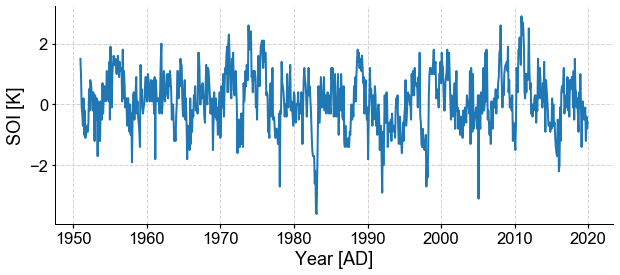

In [5]:
ts = pyleo.Series(time=to, value=Xo, time_name='Year', time_unit='AD', value_name='SOI', value_unit='K')
# print(ts)

fig, ax = ts.plot()
# fig, ax = ts.plot(marker='o', color='r', legend=True, label='SOI')
# fig, ax = ts.plot(linewidth=1, label='SOI', legend=False)
# fig, ax = ts.plot(lgd_kwargs={'frameon': True}, linestyle='--', label='SOI')

In [7]:
fig, ax = ts.plot(savefig_settings={'path': './figs/soi.pdf'})

Figure saved at: "figs/soi.pdf"


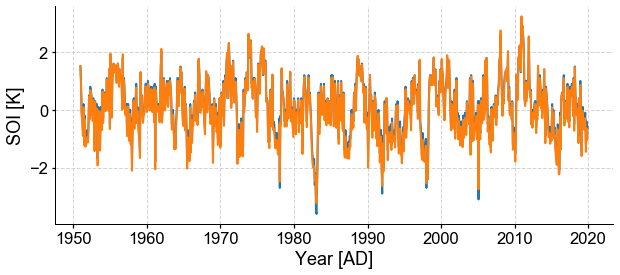

In [8]:
fig, ax = ts.plot(mute=True)

ax = ts.gaussianize().plot(ax=ax)

pyleo.showfig(fig)

##  Spectral analysis on the Series

In [9]:
%%time
psd_wwz = ts.spectral(settings={'nMC': 0})

CPU times: user 1min 27s, sys: 285 ms, total: 1min 27s
Wall time: 15.7 s


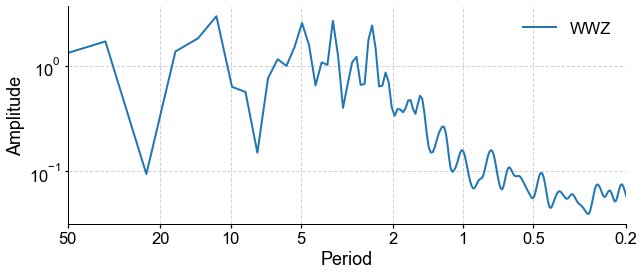

In [10]:
fig, ax = psd_wwz.plot(label='WWZ')

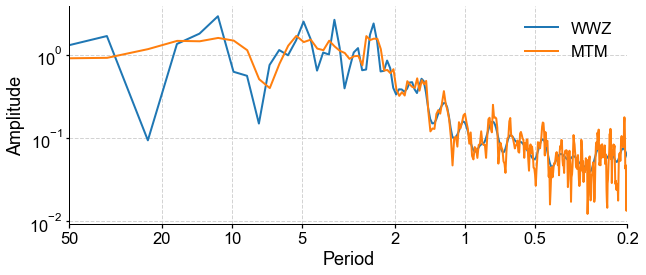

In [11]:
psd_mtm = ts.spectral(method='mtm')
ax = psd_mtm.plot(ax=ax, label='MTM')

pyleo.showfig(fig)

## Wavelet analysis on the Series

In [12]:
%%time
scal = ts.wavelet()

CPU times: user 4.93 s, sys: 49.7 ms, total: 4.98 s
Wall time: 3.64 s


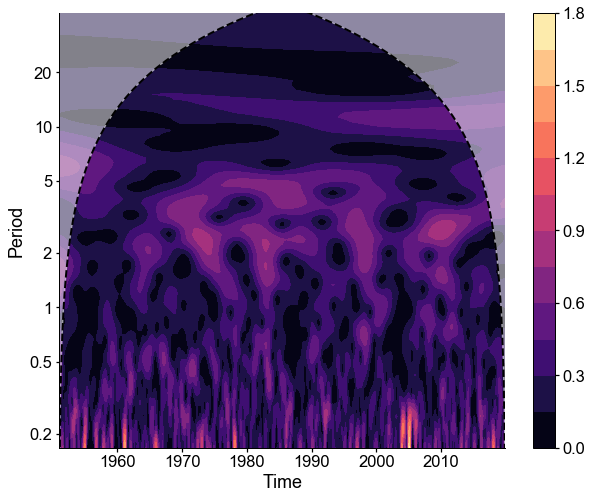

In [13]:
fig, ax = scal.plot()

## Wavelet coherence analysis on two Series objs

In [14]:
import scipy.io as sio
import matplotlib.pyplot as plt

data = sio.loadmat('../example_data/wtc_test_data_nino.mat')
air = data['air'][:, 0]
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]

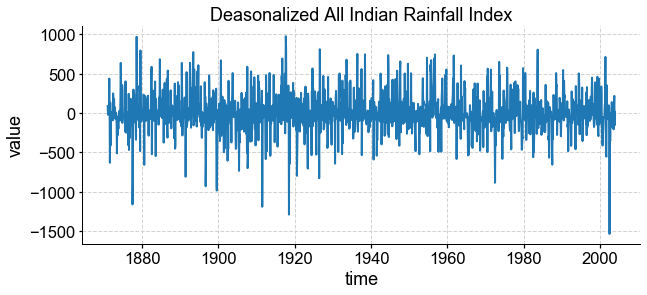

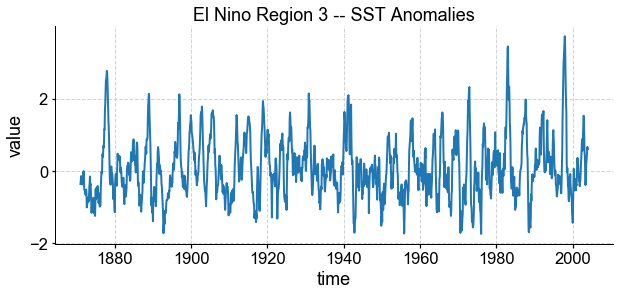

In [15]:
ts_air = pyleo.Series(time=t, value=air)
ts_nino = pyleo.Series(time=t, value=nino)

fig, ax = ts_air.plot(title='Deasonalized All Indian Rainfall Index')
fig, ax = ts_nino.plot(title='El Nino Region 3 -- SST Anomalies')

In [16]:
coh = ts_air.wavelet_coherence(ts_nino, settings={'nMC': 0})

/home/fzhu/Apps/Pyleoclim_util/pyleoclim/utils/wavelet.py:1773: UserWarning: The boundaries of tau are not exactly on two of the time axis points,and it will be adjusted to be so.
  warnings.warn("The boundaries of tau are not exactly on two of the time axis points," +


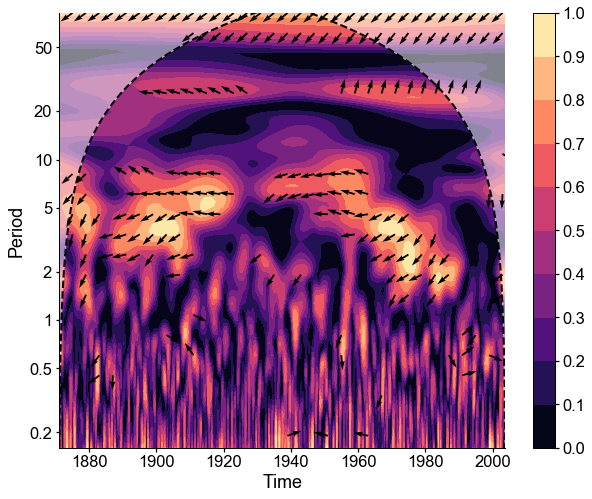

In [17]:
fig, ax = coh.plot(phase_style={'skip_x': 50})

##  Correlation analysis

In [18]:
corr_res = ts_air.correlation(ts_nino)
print(corr_res)

{'r': -0.15239413332839044, 'signif': True, 'pvalue': 0.0}


## Causality analysis

In [19]:
causal_res = ts_air.causality(ts_nino)
print(causal_res)

Calculating causality between surrogates: 100%|██████████| 1000/1000 [00:00<00:00, 1781.13it/s]

{'T21': 0.01644548028633629, 'tau21': 0.011968992003857067, 'Z': 1.3740071244960856, 'signif_qs': [0.005, 0.025, 0.05, 0.95, 0.975, 0.995], 'T21_noise': array([-9.96111870e-05, -4.11123636e-05, -1.78172023e-05,  2.92317426e-03,
        3.87387400e-03,  5.81602184e-03]), 'tau21_noise': array([-7.39768352e-05, -3.05415464e-05, -1.32332904e-05,  2.16150894e-03,
        2.86350097e-03,  4.28776998e-03])}


## Surrogates

In [20]:
surr = ts_nino.surrogates(number=100, seed=2333)

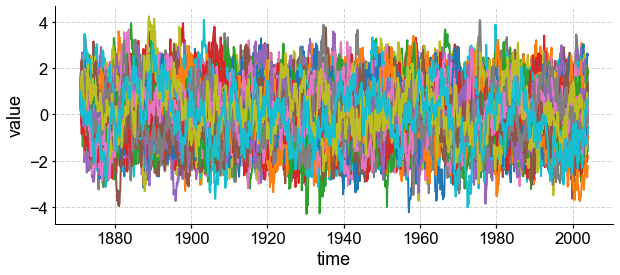

In [21]:
fig, ax = surr.plot()

In [22]:
surr_psd = surr.spectral(method='mtm')

100%|██████████| 100/100 [00:04<00:00, 24.96it/s]


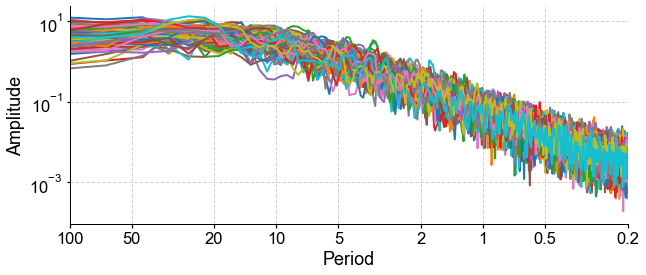

In [23]:
fig, ax = surr_psd.plot()

In [24]:
surr_qs = surr_psd.quantiles()

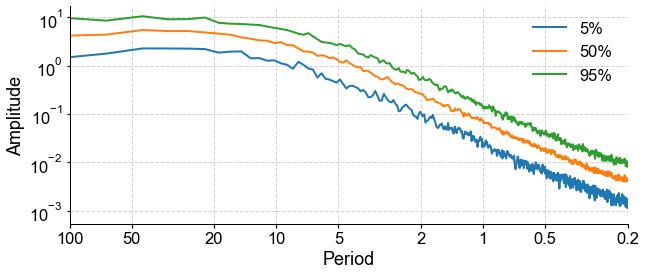

In [25]:
fig, ax = surr_qs.plot()

## Significance test with AR(1) for spectral analysis

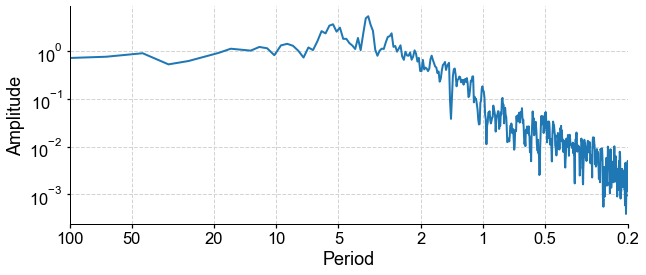

In [26]:
psd = ts_nino.spectral(method='mtm')
fig, ax = psd.plot()

In [30]:
psd = psd.signif_test()

100%|██████████| 200/200 [00:08<00:00, 22.28it/s]


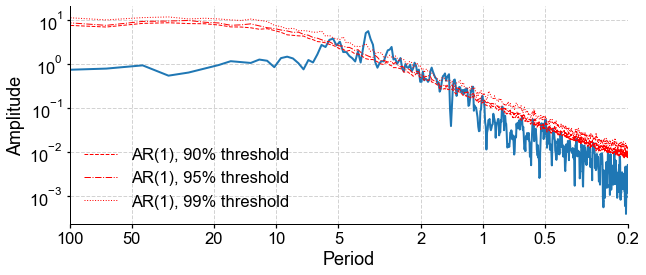

In [31]:
fig, ax = psd.plot()

100%|██████████| 200/200 [00:07<00:00, 25.46it/s]


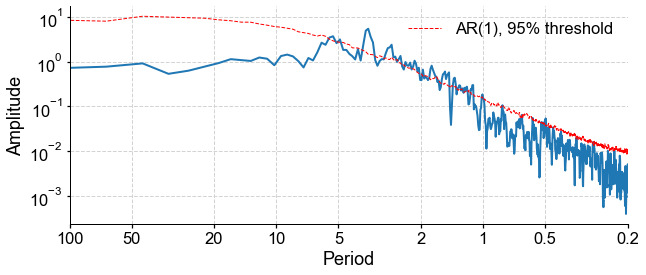

In [29]:
fig, ax = ts_nino.spectral(method='mtm').signif_test(qs=[0.95]).plot()

## Significance test in wavelet analysis

In [55]:
surr = ts.surrogates(number=2)
surr_scal = surr.wavelet()

Performing wavelet analysis on surrogates: 100%|██████████| 2/2 [00:07<00:00,  3.62s/it]


In [56]:
surr_qs = surr_scal.quantiles()

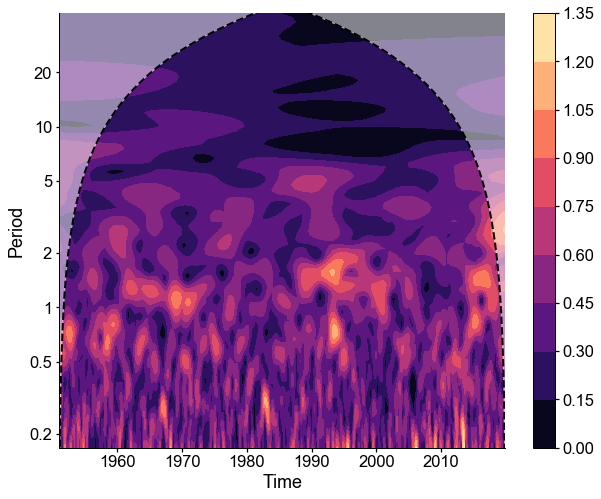

In [57]:
fig, ax = surr_qs.scalogram_list[-1].plot()

In [6]:
%%time
scal = ts.wavelet()

CPU times: user 5.02 s, sys: 41.7 ms, total: 5.06 s
Wall time: 3.71 s


In [7]:
scal = scal.signif_test(qs=[0.95], number=2)

Performing wavelet analysis on surrogates: 100%|██████████| 2/2 [00:07<00:00,  3.66s/it]


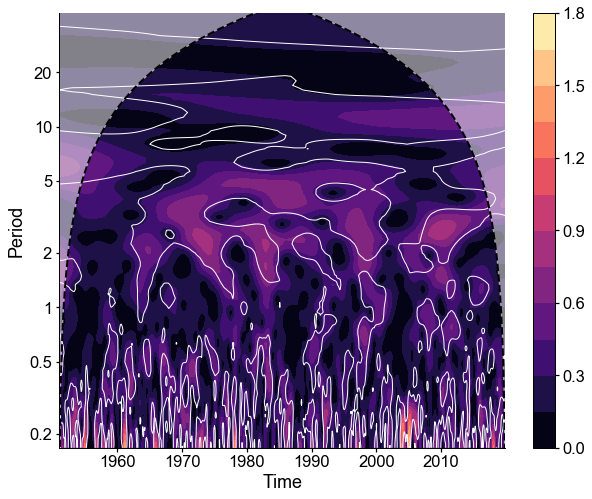

In [8]:
fig, ax = scal.plot()

Performing wavelet analysis on surrogates: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


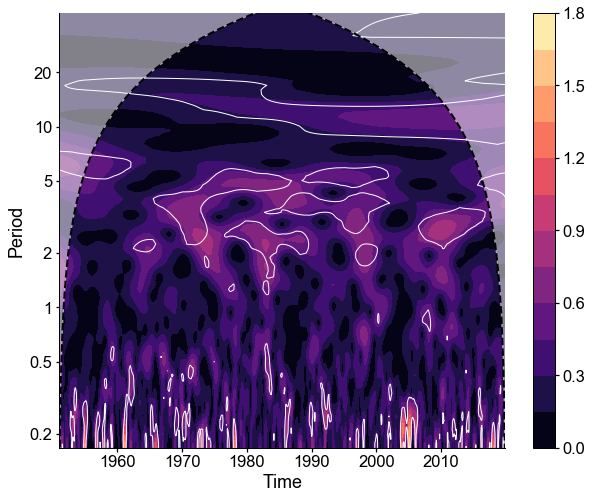

In [10]:
# one-line workflow
fig, ax = ts.wavelet().signif_test(number=10).plot()